In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd '/content/gdrive/My Drive/AI/Stock prediction'

/content/gdrive/My Drive/AI/Stock prediction


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f83vbsvt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-f83vbsvt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80706 sha256=511446c12cc4e9ab44c1ae039155652ce76fa4772ee041365f8e6c29b414d0d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2pbw42xh/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.animation as animation

import cv2
from sklearn.preprocessing import StandardScaler
from keras import backend as kr
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import os
sns.set()
tf.compat.v1.random.set_random_seed(1234)


Using TensorFlow backend.


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [7]:
#Static variables
NumberofBalls=2 #max=6
GroundLength=432.0
GroundWidth=288.0
BallRadius=30.0
Speed=70 #pixels/second
FPS=30 #frames/second
NumberofEpisodes=3
EpisodeDuration=7 #seconds
FrameNumbers=int(FPS*EpisodeDuration)
BallColors=['black','red','green','blue','gray','yellow']

def InitializeBalls(NumberofEpisodes,NumberofBalls,GroundLength,GroundWidth,BallRadius):
    Xs=BallRadius+np.repeat(np.arange(NumberofBalls).reshape(-1,1),NumberofEpisodes,axis=1)*(GroundLength-2*BallRadius)/NumberofBalls+np.random.randint(int((GroundLength-2*BallRadius)/NumberofBalls-2*BallRadius),size=(NumberofBalls,NumberofEpisodes))
    Ys=np.random.randint(BallRadius,GroundWidth-BallRadius,size=(NumberofBalls,NumberofEpisodes))/1.0 #convert to float
    Angles=np.random.randint(360, size=(NumberofBalls,NumberofEpisodes))
    return Xs, Ys, Angles
    
Xs,Ys,IAngles=InitializeBalls(NumberofEpisodes,NumberofBalls,GroundLength,GroundWidth,BallRadius)

#def Collide(Xpositions, Ypositions, Angles, GroundLength, GroundWidth, BallRadius):
def Distances(Xpositions, Ypositions):
    BallDistances=np.zeros([Xpositions.shape[0],Xpositions.shape[0],Xpositions.shape[1]])
    WallDistances=np.stack([GroundWidth-Ypositions,GroundLength-Xpositions,Ypositions,Xpositions],axis=1) #top, right, bottom, left
    for i in range(Xpositions.shape[0]):
        for j in range(i,Xpositions.shape[0]):
            for z in range(Xpositions.shape[1]):
                BallDistances[i,j,z]=np.sqrt((Xpositions[i,z]-Xpositions[j,z])**2+(Ypositions[i,z]-Ypositions[j,z])**2)
    return BallDistances, WallDistances

def Collide(Xpositions, Ypositions, Angles):
    NextYs=Ypositions+Speed/FPS*np.sin(np.deg2rad(Angles))
    NextXs=Xpositions+Speed/FPS*np.cos(np.deg2rad(Angles))
    BallDistances, WallDistances=Distances(NextXs, NextYs)
    WallCollision = WallDistances < BallRadius
    BallCollision = np.logical_and(BallDistances< (2*BallRadius), BallDistances>0)
    return WallCollision, BallCollision


def NoCollisionNextState(Xpositions, Ypositions, Angles):
    NextYs=Ypositions+Speed/FPS*np.sin(np.deg2rad(Angles))
    NextXs=Xpositions+Speed/FPS*np.cos(np.deg2rad(Angles))
    return NextXs, NextYs

def BallCollisionNextState(Xpositions, Ypositions, Angles, BallCollision):
    NextXs=Xpositions #inital value
    NextYs=Ypositions #inital value
    NextAngles=Angles #inital value
    
    Index=np.argwhere(BallCollision==True)
    for id in Index:
        XNext1, YNext1 = NoCollisionNextState(NextXs[id[0],id[2]], NextYs[id[0],id[2]], Angles[id[0],id[2]])
        XNext2, YNext2 = NoCollisionNextState(NextXs[id[1],id[2]], NextYs[id[1],id[2]], Angles[id[1],id[2]])
        ContactAngle = np.rad2deg(np.arctan((YNext2-YNext1)/(XNext2-XNext1))) + 90.0
        NextAngle1 = Angles[id[0],id[2]] + 2 * (ContactAngle - Angles[id[0],id[2]])
        NextAngle2 = Angles[id[1],id[2]] + 2 * (ContactAngle - Angles[id[1],id[2]])
        NextX1, NextY1 = NoCollisionNextState(NextXs[id[0],id[2]], NextYs[id[0],id[2]], NextAngle1)
        NextX2, NextY2 = NoCollisionNextState(NextXs[id[1],id[2]], NextYs[id[1],id[2]], NextAngle2)
        NextXs[id[0],id[2]] = NextX1
        NextXs[id[1],id[2]] = NextX2
        NextYs[id[0],id[2]] = NextY1
        NextYs[id[1],id[2]] = NextY2
        NextAngles[id[0],id[2]]=NextAngle1
        NextAngles[id[1],id[2]]=NextAngle2
        
    return NextXs, NextYs, NextAngles
def WallCollisionNextState(Xpositions, Ypositions, Angles, WallCollision):
    NextXs=Xpositions #inital value
    NextYs=Ypositions #inital value
    NextAngles=Angles #inital value
    
    #Top wall collision
    idxUp=np.argwhere(WallCollision[:,0,:]==True)
    NextYs[idxUp[:,0], idxUp[:,1]]=(GroundWidth-BallRadius)-(Ypositions[idxUp[:,0], idxUp[:,1]]+Speed/FPS*np.sin(np.deg2rad(Angles[idxUp[:,0], idxUp[:,1]]))-(GroundWidth-BallRadius))
    NextXs[idxUp[:,0], idxUp[:,1]]=Xpositions[idxUp[:,0], idxUp[:,1]]+Speed/FPS*np.cos(np.deg2rad(Angles[idxUp[:,0], idxUp[:,1]]))
    NextAngles[idxUp[:,0], idxUp[:,1]] *= -1
    
    #Right wall collision
    idxRight=np.argwhere(WallCollision[:,1,:]==True)
    NextYs[idxRight[:,0], idxRight[:,1]]=Ypositions[idxRight[:,0], idxRight[:,1]]+Speed/FPS*np.sin(np.deg2rad(Angles[idxRight[:,0], idxRight[:,1]]))
    NextXs[idxRight[:,0], idxRight[:,1]]=(GroundLength-BallRadius) - (Xpositions[idxRight[:,0], idxRight[:,1]]+Speed/FPS*np.cos(np.deg2rad(Angles[idxRight[:,0], idxRight[:,1]]))-(GroundLength-BallRadius))
    NextAngles[idxRight[:,0], idxRight[:,1]] = 180 - NextAngles[idxRight[:,0], idxRight[:,1]]
    
    #Bottom wall collision
    idxBottom=np.argwhere(WallCollision[:,2,:]==True)
    NextYs[idxBottom[:,0],idxBottom[:,1]]=BallRadius-(Ypositions[idxBottom[:,0],idxBottom[:,1]]+Speed/FPS*np.sin(np.deg2rad(Angles[idxBottom[:,0],idxBottom[:,1]])) - BallRadius) 
    NextXs[idxBottom[:,0],idxBottom[:,1]]=Xpositions[idxBottom[:,0],idxBottom[:,1]]+Speed/FPS*np.cos(np.deg2rad(Angles[idxBottom[:,0],idxBottom[:,1]]))
    NextAngles[idxBottom[:,0], idxBottom[:,1]] *= -1
    
    #Left wall collision
    idxLeft=np.argwhere(WallCollision[:,3,:]==True)
    NextYs[idxLeft[:,0], idxLeft[:,1]]=Ypositions[idxLeft[:,0], idxLeft[:,1]]+Speed/FPS*np.sin(np.deg2rad(Angles[idxLeft[:,0], idxLeft[:,1]]))
    NextXs[idxLeft[:,0], idxLeft[:,1]]=BallRadius - (Xpositions[idxLeft[:,0], idxLeft[:,1]]+Speed/FPS*np.cos(np.deg2rad(Angles[idxLeft[:,0], idxLeft[:,1]])) - BallRadius )
    NextAngles[idxLeft[:,0], idxLeft[:,1]] = 180 - NextAngles[idxLeft[:,0], idxLeft[:,1]]
    
    return NextXs, NextYs, NextAngles

def NextState(Xpositions, Ypositions, Angles):
    WallCollision, BallCollision = Collide(Xpositions, Ypositions, Angles)
    
    NextXs=Xpositions #inital value
    NextYs=Ypositions #inital value
    
    # wall collision
    NextXs, NextYs, NextAngles  = WallCollisionNextState(Xpositions, Ypositions, Angles, WallCollision)
    
    # No collision
    NoIdx=np.argwhere(np.logical_and(np.any(WallCollision==False, axis=1), np.any(BallCollision==False, axis=1)))
    NoIdx[[0, 1]] = NoIdx[[1, 0]]
    X, Y = NoCollisionNextState(Xpositions, Ypositions, Angles)
    NextXs[NoIdx[:,0], NoIdx[:,1]] = X[NoIdx[:,0],NoIdx[:,1]]
    NextYs[NoIdx[:,0], NoIdx[:,1]] = Y[NoIdx[:,0],NoIdx[:,1]]
    
    # Balls collision
    NextXs, NextYs, NextAngles = BallCollisionNextState(NextXs, NextYs, NextAngles, BallCollision)
    
    return NextXs, NextYs, NextAngles

LastXs=Xs
LastYs=Ys
LastAngles=IAngles   
for i in range(FrameNumbers):
    NewXs, NewYs, NewAngles = NextState(LastXs, LastYs, LastAngles)
    Xs=np.dstack([Xs, NewXs])
    Ys=np.dstack([Ys, NewYs])
    IAngles=np.dstack([IAngles, NewAngles])
    LastXs=NewXs
    LastYs=NewYs
    LastAngles=NewAngles
# Normalization
NormalizedXs=Xs/GroundLength
NormalizedYs=Ys/GroundWidth
# save csv
TrainingFrames=2;
PredictedFrames=1;
Xtrain=[];
Ytrain=[];
Xtest=[];
Ytest=[];
#Train=tf.zeros([0, 8], tf.float32)
Train=[]
TrainingEpisodes=NumberofEpisodes-1;
for episode in range(TrainingEpisodes+1):
    
    for i in range(NormalizedXs.shape[2]-TrainingFrames-PredictedFrames):
        a=np.concatenate((NormalizedXs[:,episode,i:i+TrainingFrames], NormalizedYs[:,episode,i:i+TrainingFrames]))
        b=np.concatenate((NormalizedXs[:,episode,i+TrainingFrames+1:i+TrainingFrames+PredictedFrames+1],NormalizedYs[:,episode,i+TrainingFrames+1:i+TrainingFrames+PredictedFrames+1]))
        #new=tf.constant([a,b], tf.float32) NumberofBalls
        #print(a.shape)
        #print(b.shape)
        new=[tf.constant(a.reshape([1,TrainingFrames*NumberofBalls*2]),tf.float32),tf.constant(b.reshape(1,PredictedFrames*NumberofBalls*2),tf.float32)]
        #Train=tf.concat([Train,new],0)
        #Train=np.vstack((Train,new))
        Train.append(new)

print(len(Train))            
            
#Test=tf.zeros([0, 8], tf.float32)
Test=[]
for episode in range(TrainingEpisodes,NumberofEpisodes):
    for ball in range(NormalizedXs.shape[0]):
        for i in range(NormalizedXs.shape[2]-TrainingFrames-PredictedFrames):
            a=np.concatenate((NormalizedXs[:,episode,i:i+TrainingFrames], NormalizedYs[:,episode,i:i+TrainingFrames]))
            b=np.concatenate((NormalizedXs[:,episode,i+TrainingFrames+1:i+TrainingFrames+PredictedFrames+1],NormalizedYs[:,episode,i+TrainingFrames+1:i+TrainingFrames+PredictedFrames+1]))
            #new=tf.constant([a,b], tf.float32)
            new=[tf.constant(a.reshape([1,TrainingFrames*NumberofBalls*2]),tf.float32),tf.constant(b.reshape(1,PredictedFrames*NumberofBalls*2),tf.float32)]
            #Test=tf.concat([Test,new],0)
            Test.append(new)
print(len(Test)) 

624
416


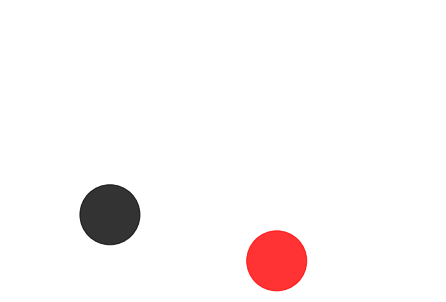

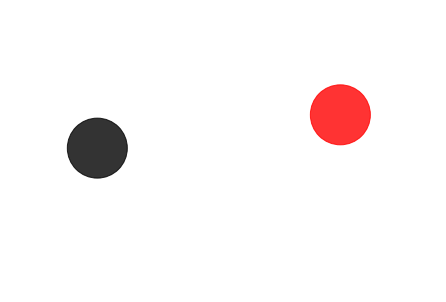

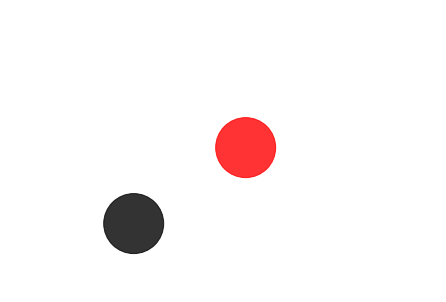

In [8]:
def RunAnimation(Episode):    
    fig = plt.figure()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax = plt.axes(xlim=(0, 432), ylim=(0, 288))
    ax.set_facecolor('white')
    plt.axis('off')
    ##creating list of patches
    Balls = []
    for n in range(NumberofBalls):
        Balls.append(mpl.patches.Circle((Xs[n,0,i], Ys[n,0,i]), radius = BallRadius, color = BallColors[n], lw = 1, alpha = 0.8, zorder = 4))
    ## adding patches to axis
    for Ball in Balls:
        ax.add_patch(Ball)

    anim = animation.FuncAnimation(fig, animate, frames=Xs.shape[2], fargs=(Episode,Balls), interval=20, blit=False)
    plt.show()
    anim.save("Videos/Episode"+str(Episode)+".mp4", fps=FPS, extra_args=['-vcodec', 'h264', '-pix_fmt', 'yuv420p'])

def animate(i,episode,Balls):
    for n,ball in enumerate(Balls):
        ball.center = (Xs[n,episode,i], Ys[n,episode,i])
for i in range(NumberofEpisodes):
    RunAnimation(i)

In [0]:
NumberofFrames=FrameNumbers*NumberofEpisodes
TrainingData=np.zeros((NumberofFrames,288,432,3))
for Episode in range(NumberofEpisodes):
  vidcap = cv2.VideoCapture("Videos/Episode"+str(Episode)+".mp4")

  success,image = vidcap.read()
  
  count = 0
  Images=np.expand_dims(image,axis=0);
  while success:
    try:
      success,image = vidcap.read()
      #print('Read a new frame: ', success)
      image=np.expand_dims(image,axis=0)
      count += 1
      Images=np.concatenate([Images,image],axis=0)
    except:
      break
  #TrainingData=np.append(TrainingData,Images[:-1,:,:,:],axis=0)
  TrainingData[Episode*FrameNumbers:(Episode+1)*FrameNumbers,:,:,:]=Images[:-1,:,:,:]
TrainingData=(TrainingData-128.0)/256.0


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(288, 432, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='sigmoid'))
optimizer = tf.keras.optimizers.RMSprop(0.1)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mae'])
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
try:
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(latest)
  print('loaded')
except Exception:
  pass
ALL=model.predict(TrainingData)
df_log=pd.DataFrame(ALL[0:FrameNumbers,:])
df=df_log

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
loaded


In [0]:
#ALL=np.vstack((NormalizedXs,NormalizedYs))
#print(ALL.shape)
#df_log=pd.DataFrame(ALL[:,0,:].T)
#print(df_log.shape)
#df=df_log

In [11]:
test_size = 60
simulation_size = NumberofEpisodes

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((210, 4), (150, 4), (60, 4))

In [0]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size, activation=tf.nn.sigmoid)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real)
    predict = np.array(predict)
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
num_layers = 1
size_layer = 128 #128
timestamp = 5 #5
epoch = 300
dropout_rate = 0.8 #0.8
future_day = test_size
learning_rate = 0.001

In [0]:

def forecast():
    tf.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y, logits))
            #total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    #return output_predict[-test_size:,:]
    #return np.flip(output_predict[-test_size:,:],axis=0)
    print(output_predict.shape)
    deep_future = anchor(output_predict, 0.3)
    #deep_future=output_predict.tolist()
    return deep_future[-test_size:]
    

In [34]:
results = []
PREDICTIONS=np.empty([4, test_size, simulation_size])
TrueValues=np.empty([4, test_size, simulation_size])
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    df_log=pd.DataFrame(ALL[FrameNumbers*i:FrameNumbers*(i+1),:])
    df=df_log
    df_train = df_log.iloc[:-test_size]
    df_test = df_log.iloc[-test_size:]
    out=forecast()
    results.append(out)
    PREDICTIONS[:,:,i]=np.asarray(out).T
    #TrueValues[:,:,i]=df_train.iloc[-test_size:].values.T
    TrueValues[:,:,i]=df_test.iloc[-test_size:].values.T

simulation 1


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train loop:   0%|          | 0/300 [00:00<?, ?it/s]

train loop:   0%|          | 0/300 [00:00<?, ?it/s, acc=22.3, cost=0.0295]

train loop:   0%|          | 1/300 [00:00<01:46,  2.80it/s, acc=22.3, cost=0.0295]

train loop:   0%|          | 1/300 [00:00<01:46,  2.80it/s, acc=3.15, cost=0.0676]

train loop:   1%|          | 2/300 [00:00<01:33,  3.18it/s, acc=3.15, cost=0.0676]

train loop:   1%|          | 2/300 [00:00<01:33,  3.18it/s, acc=9.56, cost=0.0682]

train loop:   1%|          | 3/300 [00:00<01:24,  3.50it/s, acc=9.56, cost=0.0682]

train loop:   1%|          | 3/300 [00:01<01:24,  3.50it/s, acc=21.2, cost=0.0593]

KeyboardInterrupt: ignored

In [0]:
accs=[];
for j in range(test_size):
  acc=calculate_accuracy(TrueValues[:,j,:], PREDICTIONS[:,j,:])
  accs.append(acc)

Text(0, 0.5, 'Average accuracy')

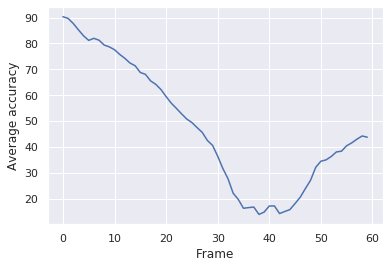

In [17]:
plt.plot(accs)
plt.xlabel('Frame')
plt.ylabel('Average accuracy')

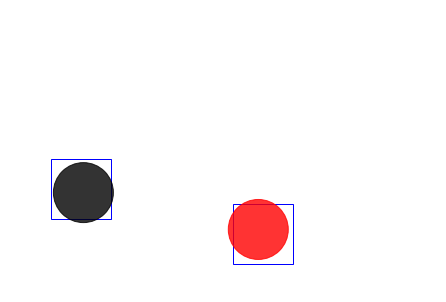

In [26]:
TestEpisode=2
PredictionFrames=np.ones([Xs.shape[2],4])*(-1)
PredictionFrames[151:211,:]=PREDICTIONS[:,:,TestEpisode-1].T
def Visualization(Episode):    
    fig = plt.figure()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax = plt.axes(xlim=(0, 432), ylim=(0, 288))
    ax.set_facecolor('white')
    plt.axis('off')
    ##creating list of patches
    Balls = []
    Squares=[]
    PredictionSquares=[]
    for n in range(NumberofBalls):
        Balls.append(mpl.patches.Circle((Xs[n,TestEpisode-1,i], Ys[n,TestEpisode-1,i]), radius = BallRadius, color = BallColors[n], lw = 1, alpha = 0.8, zorder = 4))
    for n in range(NumberofBalls):
        Squares.append(mpl.patches.Rectangle((ALL[(TestEpisode-1)*(Xs.shape[2]-1)+i,n]*500-BallRadius,ALL[(TestEpisode-1)*(Xs.shape[2]-1)+i,n+2]*500-BallRadius), BallRadius*2, BallRadius*2, angle=0.0, fill=False, color="blue"))
        PredictionSquares.append(mpl.patches.Rectangle((PredictionFrames[i,n]*500-BallRadius,PredictionFrames[i,n+2]*500-BallRadius), BallRadius*2, BallRadius*2, angle=0.0, fill=False, color=BallColors[n]))
    
    ## adding patches to axis
    for Ball in Balls:
        ax.add_patch(Ball)
    for Square in Squares:
        ax.add_patch(Square)
    for PredictionSquare in PredictionSquares:
      ax.add_patch(PredictionSquare)
    anim = animation.FuncAnimation(fig, animate2, frames=Xs.shape[2]-1, fargs=(Episode,Balls,Squares,PredictionSquares), interval=20, blit=False)
    plt.show()
    anim.save("Videos/Prediction"+str(Episode)+".mp4", fps=FPS, extra_args=['-vcodec', 'h264', '-pix_fmt', 'yuv420p'])

def animate2(i,episode,Balls,Squares,PredictionSquares):
    for n,ball in enumerate(Balls):
        ball.center = (Xs[n,episode,i], Ys[n,episode,i])
    for n,square in enumerate(Squares):
        square.xy = (ALL[(TestEpisode-1)*(Xs.shape[2]-1)+i,n]*500-BallRadius,ALL[(TestEpisode-1)*(Xs.shape[2]-1)+i,n+2]*500-BallRadius)
    for n,predictionsquare in enumerate(PredictionSquares):
        predictionsquare.xy=(PredictionFrames[i,n]*500-BallRadius,PredictionFrames[i,n+2]*500-BallRadius)
        
for i in range(1):
    Visualization(TestEpisode-1)

In [18]:
print(PREDICTIONS[:,:,2]*500)

[[331.02621195 330.55038916 330.51493367 330.94161928 330.43645376
  330.06460534 330.77685555 329.94795001 329.83149933 329.87158253
  329.4076495  329.28655662 330.3461734  330.30703257 331.05041859
  330.09356343 330.71768011 330.27445592 328.7233988  329.63300882
  326.42884296 329.14374543 329.78181026 330.20314569 330.45517503
  330.94440728 328.21262726 329.25474301 328.55648594 328.97083401
  329.27137744 330.30486146 328.61650896 330.06273482 330.6296163
  330.62502722 330.84497148 331.12881271 329.87971809 330.30659767
  330.53018693 326.77084519 329.68055997 330.83815215 328.90731942
  330.43989197 330.2194287  329.81170147 329.07989004 330.70263677
  331.04140584 331.23284586 327.00164916 328.491866   330.47084195
  329.53208143 330.6877567  328.13928287 330.07993031 329.96513763]
 [371.85569862 372.34023589 372.37160914 371.99332867 372.45333062
  372.80695697 371.9976576  372.75151109 372.99548297 373.02935037
  373.2044426  373.26631628 372.43564332 372.56691576 371.6468

In [29]:
print(TrueValues[:,:,2]*500)

[[112.18652129 113.10783029 112.76206374 114.76062238 116.35713279
  114.98963833 115.6283617  115.91888964 115.31294882 117.34981835
  117.90132523 117.43320525 117.36445129 118.84573102 119.52960491
  120.79839408 122.42403626 123.94753098 125.81424415 126.18067861
  126.36828423 127.17798352 128.63129377 129.64755297 130.75198233
  130.65598905 134.97412205 135.94070077 134.10434127 133.49595666
  134.27908719 132.66503811 131.47252798 133.28963518 134.15959477
  134.29868221 133.69652629 134.39239562 137.05602288 138.06380332
  137.17594743 137.93972135 138.20573688 140.32539725 142.87951589
  142.0185864  140.20016789 141.0472095  141.95477962 145.17590404
  145.25282383 147.14978635 148.54976535 149.26032722 149.37666059
  148.6236304  149.81555939 149.80855584 148.92977476 150.92363954]
 [157.27129579 156.0407877  155.09261191 154.74048257 154.63767946
  153.22251618 150.40171146 149.33754504 146.94131911 146.82285488
  146.19110525 145.36288381 145.74638009 145.36869526 136.925

In [67]:
print(ALL[180:270,3])

[0.4554006  0.4554013  0.47081384 0.47947228 0.4875955  0.509165
 0.50844115 0.4948811  0.500324   0.4989257  0.48509112 0.46963903
 0.45101953 0.44314808 0.43821767 0.43043327 0.41679922 0.4108364
 0.39693192 0.39190426 0.38947713 0.38934723 0.3845117  0.37715146
 0.36701882 0.3577853  0.350006   0.33595544 0.31879282 0.30899054
 0.31814313 0.31484288 0.315516   0.3111335  0.31092584 0.31284833
 0.3101634  0.3065682  0.3061886  0.30636126 0.31270915 0.317406
 0.3170237  0.32021216 0.3187048  0.32219625 0.32620686 0.3309753
 0.32629347 0.3146921  0.30981746 0.31726596 0.31562495 0.31574857
 0.3284899  0.32699952 0.3224635  0.3232124  0.33290404 0.33915764
 0.33650118 0.34193563 0.35229015 0.34777611 0.35359102 0.35840285
 0.3510927  0.35501766 0.3448232  0.3442912  0.34621227 0.3636458
 0.36419505 0.3625856  0.3591231  0.35752174 0.3563165  0.36121842
 0.36527535 0.36080486 0.3730107  0.36946905 0.36120126 0.35604993
 0.3565613  0.36311167 0.37314254 0.36913806 0.36572498 0.36932665]


In [66]:
print(Ys[0,2,1:91])

[243.4240481  245.8480962  248.2721443  250.6961924  253.12024051
 255.54428861 257.96833671 253.18356709 250.75951899 248.33547089
 245.91142279 243.48737468 241.06332658 238.63927848 236.21523038
 233.79118228 231.36713418 228.94308608 226.51903798 224.09498987
 221.67094177 219.24689367 216.82284557 214.39879747 211.97474937
 209.55070127 207.12665317 204.70260506 207.27840636 212.27840636
 217.27840636 222.27840636 227.27840636 232.27840636 237.27840636
 242.27840636 247.27840636 252.27840636 257.27840636 248.72159364
 243.72159364 238.72159364 233.72159364 228.72159364 223.72159364
 218.72159364 213.72159364 208.72159364 203.72159364 198.72159364
 193.72159364 188.72159364 183.72159364 178.72159364 173.72159364
 168.72159364 163.72159364 158.72159364 153.72159364 148.72159364
 143.72159364 138.72159364 133.72159364 128.72159364 123.72159364
 118.72159364 113.72159364 108.72159364 103.72159364  98.72159364
  93.72159364  88.72159364  83.72159364  78.72159364  73.72159364
  68.72159